In [1]:
# import necessary dependencies
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import *
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from resnet import *
import pickle
import datetime

In [2]:
# select GPU if available, else CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# define transformations on training set and testing set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # CIFAR-10 normalization, check: https://stackoverflow.com/questions/50710493/cifar-10-meaningless-normalization-values
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [4]:
# get CIFAR-10 dataset and prepare train and test loaders
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# classes of CIFAR-10, in order
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
# training function
def train(epoch, net):
    '''
    this function trains network on training dataset
    '''
    # set network to training mode
    net.train()
    
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # move data to device - GPU or CPU, as available
        inputs, targets = inputs.to(device), targets.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # calculate training loss
        train_loss += loss.item()
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    return train_loss/len(trainloader)

In [6]:
# testing function
# reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=cifar
def test(epoch, net):
    '''
    this function evaluates network on testing dataset
    '''
    # set variable for global access
    global acc
    
    # set network to testing mode
    net.eval()
    
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    acc = 100 * correct / total
    
    return test_loss/len(testloader)

In [8]:
# build ResNet-18 model
net = ResNet18()
net = net.to(device)
# setup for data parallel operations
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

# initialize loss function, optimizer and LR scheduler
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [9]:
# train and evaluate naive network
train_losses=[]
test_losses=[]
epochs=20

# get a sense of execution time
print(datetime.datetime.now())

# run through number of epochs
for epoch in range(0, epochs):
    train_losses.append(train(epoch, net))
    test_losses.append(test(epoch, net))
    scheduler.step()

print(datetime.datetime.now())

2022-05-16 14:35:49.423222
2022-05-16 14:45:09.193354


In [10]:
print(f"Accuracy of the naive network on test images: {acc} %")

Accuracy of the naive network on test images: 90.01 %


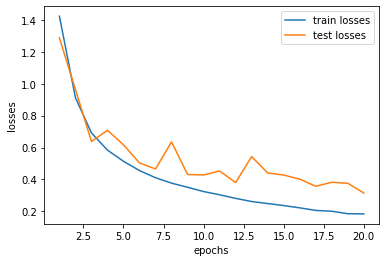

In [11]:
# plot train and test loss of naive network on CIFAR-10 images
epochs = 20
plt.plot(np.arange(1,epochs+1), train_losses, label='train losses')
plt.plot(np.arange(1,epochs+1), test_losses, label='test losses')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.show()

### PGD attack function
In the PGD attack, we repeat $\delta:=\mathcal{P}(\delta+\alpha \nabla_{\delta} L(\theta, x, y))$ for $t$ iterations.

In [12]:
def PGD(net,x,y,alpha,epsilon,iter):
    '''
    inputs:
        net: the network through which we pass the inputs
        x: the original example which we aim to perturb to make an adversarial example
        y: the true label of x
        alpha: step size
        epsilon: perturbation limit
        iter: number of iterations in the PGD algorithm

    outputs:
        x_adv : the adversarial example constructed from x
        h_adv: output of softmax when applying net on x_adv 
        y_adv: predicted label for x_adv
        pert: perturbation applied to x (x_adv - x)
    '''

    delta = torch.zeros_like(x, requires_grad=True)
    
    for i in range(iter):
        criterion = nn.CrossEntropyLoss()
        loss = criterion(net(x + delta), y)
        loss.backward()
        delta.data = (delta + x.shape[0]*alpha*delta.grad.data).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    
    pert = delta.detach()
    x_adv = x + pert
    h_adv = net(x_adv)
    _, y_adv = torch.max(h_adv.data, 1)
    
    return x_adv, h_adv, y_adv, pert

#### Adversarial training with PGD

In [13]:
net_pgd = ResNet18()
net_pgd = net_pgd.to(device)
if device == 'cuda':
    net_pgd = torch.nn.DataParallel(net_pgd)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer_pgd = optim.SGD(net_pgd.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler_pgd = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_pgd, T_max=200)

In [14]:
# train_pgd() trains a given neural network on adversarial examples generated from training data using the
# PGD attack
def train_pgd(epoch, net, alpha, epsilon, iter):
    net.train()
    
    train_loss = 0
    correct = 0
    total = 0
    eps = 8.0/255
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        x_adv, _, _, _ = PGD(net, inputs, targets, alpha, epsilon, iter)

        optimizer_pgd.zero_grad()
        outputs = net(x_adv)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_pgd.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    return train_loss/len(trainloader)

In [15]:
# train and evaluate adversarially-trained network on unperturbed images

train_losses_pgd = []
test_losses_pgd = []
epochs = 20
alpha = 3.0/255
epsilon = 8.0/255
iter = 3

print(datetime.datetime.now())

for epoch in range(0, epochs):
    train_losses_pgd.append(train_pgd(epoch, net_pgd, alpha, epsilon, iter))
    test_losses_pgd.append(test(epoch, net_pgd))
    scheduler_pgd.step()

print(datetime.datetime.now())

2022-05-16 14:48:42.830294
2022-05-16 15:23:55.786987


In [16]:
print(f"Accuracy of the adversarially-trained network on unperturbed test images: {acc} %")

Accuracy of the adversarially-trained network on unperturbed test images: 89.07 %


In [ ]:
torch.save(net_pgd, "pgd.pth")

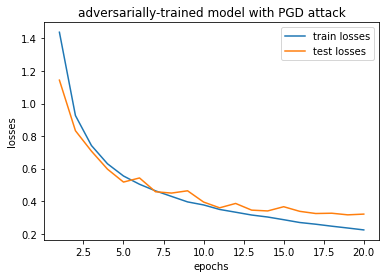

In [17]:
# plot losses
epochs = 20
plt.plot(np.arange(1,epochs+1), train_losses_pgd, label='train losses')
plt.plot(np.arange(1,epochs+1), test_losses_pgd, label='test losses')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.title('adversarially-trained model with PGD attack')
plt.legend()
plt.show()

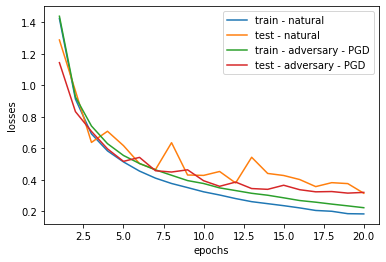

In [18]:
# comparing plots
# train - natural: training loss of the naturally-trained model
# test - natural: loss of the naturally-trained model on original (unperturbed) test images
# train - adversary - PGD: training loss of the adversarially-trained model (on examples generated with PGD)
# test - adversary - PGD: loss of the adversarially-trained model on original (unperturbed) test images
epochs = 20
plt.plot(np.arange(1,epochs+1), train_losses, label='train - natural')
plt.plot(np.arange(1,epochs+1), test_losses, label='test - natural')
plt.plot(np.arange(1,epochs+1), train_losses_pgd, label='train - adversary - PGD')
plt.plot(np.arange(1,epochs+1), test_losses_pgd, label='test - adversary - PGD')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend()
plt.show()

In [19]:
# Evaluating the PGD adversarially-trained model against PGD attack on test data
# test_PGD() constructs adversarial examples from test data (with PGD using net) and evaluates net_pgd on them.
def test_PGD(net, net_pgd, alpha, eps, iter):
    acc = 0
    
    net.train()
    net_pgd.eval()
    
    test_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        x_adv, _, _, _ = PGD(net, inputs, targets, alpha, eps, iter)

        with torch.no_grad():
            outputs = net_pgd(x_adv)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    acc = 100 * correct / total
    
    return acc

In [20]:
# study of accuracy on varying iterations
alpha = 3.0/255
eps = 8.0/255

for iter in [3, 7, 12]:
    acc = test_PGD(net, net_pgd, alpha, eps, iter)
    print(f"Accuracy of net_pgd against PGD attack with iters = {iter} : {acc} %")

Accuracy of net_pgd against PGD attack with iters = 3 : 87.92 %
Accuracy of net_pgd against PGD attack with iters = 7 : 86.41 %
Accuracy of net_pgd against PGD attack with iters = 12 : 84.94 %


In [10]:
# export ipynb as pdf
# !apt-get -y install pandoc
# !apt-get -y update && DEBIAN_FRONTEND=noninteractive apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic